# Autoencoder training

In [2]:
import datetime
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import tensorflow as tf

from rich import print
from sys import platform
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Convolution2D, AvgPool2D, MaxPooling2D, Convolution2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.metrics import MeanSquaredError, BinaryCrossentropy

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")

2023-10-31 11:23:19.577403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 11:23:19.577432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 11:23:19.577456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 11:23:19.584398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 11:23:20.895181: I tensorflow/compiler/

Num GPUs Available:  1

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.- Loading the dataset.

First, we need to load the images that will be used to train the autoencoder. The function _load_hdf5_files_ takes as inputs a direcotry path in which the hdf5 files with the images are stored, and the number of files to load within that directory. The files are randomly sampled. It returns three numpy arrays, that serve as train, validation and test datasets.

In [3]:
def load_hdf5_files(directory, n = None):
    """
    Load random HDF5 files containing images from a specified directory and concatenate them into a single NumPy array.

    Args:
        directory (str): The path to the directory containing HDF5 files.
        n (int): The number of random files to load.

    Returns:
        train_data: A  NumPy array containing all the images from the train dataset of the loaded HDF5 files.
        validation_data: A single NumPy array containing all the images from the validation dataset of the loaded HDF5 files.
        test_data: A single NumPy array containing all the images from the the test dataset of the loaded HDF5 files.

    The function selects 'n' random HDF5 files from the specified 'directory', reads the datasets from each
    file, and concatenates these datasets into a single NumPy array. This array contains all the images from the loaded
    HDF5 files. The function returns three arrays, one each for training, validation and test.

    Note:
    - Ensure that the HDF5 files in the directory have datasets named 'train', 'validation', and  'test' (or adjust accordingly).
    - If 'n' is greater than the number of available HDF5 files in the directory, all available files will be loaded.
    - if 'n' is not specified, all available files will be loaded

    Example usage:
    >>> directory_path = '/path/to/your/directory'
    >>> n = 3
    >>> train_data, val_data, test_data = load_random_hdf5_files(directory_path, n_files_to_load)
    """

    file_list = []
    # List all HDF5 files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".hdf5"):
            file_list.append(os.path.join(directory, filename))
    if not file_list:
        print("No HDF5 files found in the specified directory.")
        return None
    if (n > len(file_list)) or (n is None):
        print(f"Requested to load {n} files, but there are only {len(file_list)} files available.")
        n = len(file_list)

    # Randomly select n files
    random_files = random.sample(file_list, n)
    train_data = []
    validation_data = []
    test_data = []
    for file_path in random_files:
        with h5py.File(file_path, 'r') as hf:
            d1 = np.array(hf["train"])
            d2 = np.array(hf["validation"])
            d3 = np.array(hf["test"])
            train_data.append(np.array(d1))
            validation_data.append(np.array(d2))
            test_data.append(np.array(d3))
    # Concatenate the individual arrays into a single NumPy array
    train_data = np.concatenate(train_data, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_data = np.concatenate(test_data, axis=0)

    img_shape = train_data[0].shape
    re_shape = (-1,) + img_shape + (1,)
    print("Sets will be of shape: {}".format(re_shape))
    
    train_data = train_data.reshape(re_shape)
    validation_data = validation_data.reshape(re_shape)
    test_data = test_data.reshape(re_shape)

    return train_data, validation_data, test_data

In [4]:
if platform == 'darwin':
    images_path = "/Users/lmiguelmartinez/Tesis/datasets/highD/images_1000ms"
else:
    images_path = "/home/lmmartinez/Tesis/datasets/highD/images_1000ms"

train_data, val_data, test_data = load_hdf5_files(images_path, n = 1)
os.makedirs('/tmp/logs', exist_ok=True)
tensorboard_log_dir = '/tmp/logs/'
IMAGE_SIZE = train_data[0].shape
BATCH_SIZE = 256
print("Images are of size {}".format(IMAGE_SIZE))

Sets will be of shape: (-1, 121, 201, 1)

Images are of size (121, 201, 1)

### 1.1 Data Inspection

Once the data has been loaded, a few sample images are plotted to verify its integrity.

Total training  images: 8373

Total validation images: 2791

Total test images: 2791

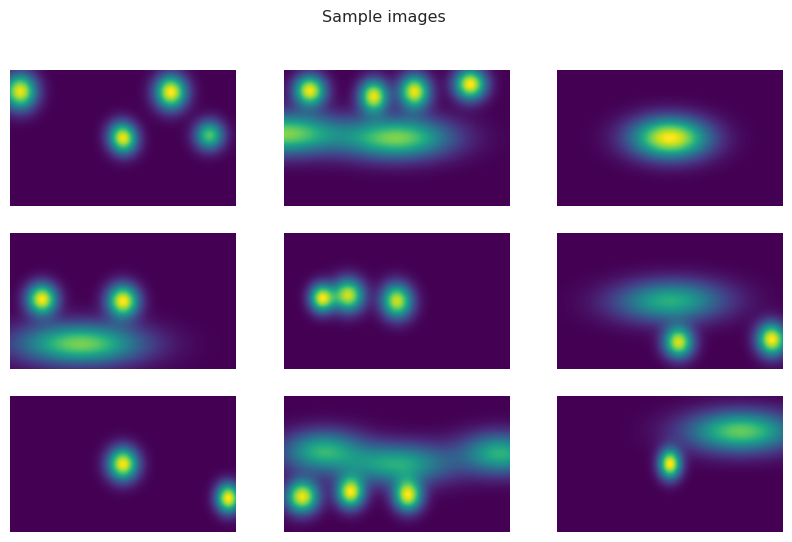

In [5]:
print('Total training  images:', len(train_data))
print('Total validation images:', len(val_data))
print('Total test images:', len(test_data))

plot_size = 3
pic_index = np.random.randint(plot_size, np.min([len(train_data), len(val_data), len(test_data)]))

next_train = [img for img in train_data[pic_index-plot_size:pic_index]]
next_val = [img for img in val_data[pic_index-plot_size:pic_index]]
next_test = [img for img in test_data[pic_index-plot_size:pic_index]]

plt.figure(figsize=(10, 6))
for i, img in enumerate(next_train+next_val+next_test):
    plt.subplot(3, plot_size, i+1)
    plt.imshow(img, cmap = 'viridis')
    plt.axis('Off')
plt.suptitle("Sample images")
plt.show()

## 2.- Model definition.

To define the autoencoder we will use four dictionaries: encoder-decoder architecture, training configuration and model parameters. The class AutoEncoder implements the necessary steps to train the Autoencoder and perform validation and testing tasks.

In [6]:
class AutoEncoder:
    def __init__(self, input_shape = None, train_config = None, model_config = None, encoder_config = None, decoder_config = None):
        self.train_config = train_config
        self.encoder_config = encoder_config
        self.decoder_config = decoder_config
        self.model_config = model_config
        self.input_shape = input_shape

        self.encoder = None
        self.decoder = None
        self.model = None

    def buildModel(self, arch_config = None):
        model = Sequential()
        for layer in arch_config.keys():
            layer_identifier = re.split('_',layer)[0]
            layer_callable = arch_config[layer]['Type']
            if (layer_identifier == 'Input'):
                # x = layer_callable(shape = arch_config[layer]['Shape'])
                continue
            elif (layer_identifier == 'LSTM'):
                x = layer_callable(arch_config[layer]['Units'], activation = arch_config[layer]['Activation'], return_sequences = arch_config[layer]['return_sequences'], name = layer)
            elif (layer_identifier == 'GRU'):
                x = layer_callable(arch_config[layer]['Units'], activation = arch_config[layer]['Activation'], return_sequences = arch_config[layer]['return_sequences'], name = layer)
            elif (layer_identifier == 'Conv2D') or (layer_identifier == 'Deconv2D'):
                x = layer_callable(filters = arch_config[layer]['Filters'], kernel_size = arch_config[layer]['Kernel size'], padding=arch_config[layer]["Padding"], strides = arch_config[layer]['Strides'], activation = arch_config[layer]['Activation'], name = layer)
            elif (layer_identifier == 'MaxPooling2D') or (layer_identifier == 'AvgPooling2D'):
                x = layer_callable(pool_size=arch_config[layer]["Pool size"], strides=arch_config[layer]["Strides"], padding=arch_config[layer]["Padding"])
            elif (layer_identifier == 'Dense'):
                x = layer_callable(arch_config[layer]['Units'], name = layer)
            elif (layer_identifier == 'Flatten'):
                x = layer_callable()
            elif (layer_identifier == 'Dropout'):
                x = layer_callable(arch_config[layer]['Value'], name = layer)
            elif (layer_identifier == 'BatchNormalization'):
                x = layer_callable(momentum = arch_config[layer]['Value'], name = layer)
            model.add(x)
        return model
    
    def buildAutoencoder(self):
        self.encoder = self.buildModel(arch_config=self.encoder_config)
        self.decoder = self.buildModel(arch_config=self.decoder_config)

        input_tensor = Input(shape=self.encoder_config['Input_1']['Shape'])
        latent_vector = self.encoder(input_tensor)
        output = self.decoder(latent_vector)
        self.model = Model(input_tensor, output)
        self.compileModel()
        
    def compileModel(self):
        loss_fun = self.model_config['loss']
        opt = self.model_config['opt']
        name = self.model_config['name']
        print("Loss, optimizer and metric set up")
        self.model._name = name
        self.model.compile(loss = loss_fun, optimizer = opt)
        print("Model created:")
        self.model.summary()
        print("Model has been built")

    def trainModel(self, train_data, val_data, log_dir):
        batch_size = self.train_config['batch_size']
        epochs = self.train_config['epochs']
        shuffle = self.train_config['shuffle']
        patience = self.train_config['ES_patience']
        min_delta = self.train_config['ES_min_delta']
        verbose = self.train_config['verbose']
        
        earlyStopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        verbose=1,
        min_delta = min_delta,
        restore_best_weights = True)

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=1)

        self.history = self.model.fit(
            x=train_data,
            y=train_data,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(val_data, val_data),
            shuffle=shuffle,
            callbacks = [earlyStopping, tensorboard_callback],
            steps_per_epoch=None,
            validation_freq=1,
        )

        return self.history

    def predict(self, test_set):
        pass
        
    def plot_history(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        plt.figure(figsize=(14, 4))
        plt.subplot(1, 2, 1)
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(loss, label='Training set')
        plt.plot(val_loss, label='Validation set', linestyle='--')
        plt.legend()
        plt.grid(linestyle='--', linewidth=1, alpha=0.5)

        # plt.subplot(1, 2, 2)
        # plt.title('Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.plot(accuracy, label='Training set')
        # plt.plot(val_accuracy, label='Validation set', linestyle='--')
        # plt.legend()
        # plt.grid(linestyle='--', linewidth=1, alpha=0.5)

        plt.show()

Some important formulas: 
- Output size of convolution layer: $(W_o, H_o) = (\frac{W-K_x+2P_x}{S_x} + 1 ,  \frac{W-K_y+2P_y}{S_y} + 1 )$

- Output size of deconvoltion layer: $(W_o, H_o) = (S_x \cdot (W-1) + K_x - 2P_x, \quad S_y \cdot (H-1) + K_y - 2P_y)$

- Output size of pooling layer: $(W_o, H_o) = (\frac{W-K_x}{S_x} + 1 ,  \frac{W-K_y}{S_y} + 1 )$

In [7]:
model_config = {'name': "AutoEncoder1", 'loss': 'mean_squared_error', 'opt': 'adam'}

encoder_config = {
    'Input_1': {'Type': Input, 'Shape': train_data[0].shape},
    'Conv2D_11': {'Type': Convolution2D, 'Filters': 32, 'Kernel size': (5,5), 'Padding': 'same', 'Strides': (3,3), 'Activation': relu},
    'MaxPooling2d_12': {'Type': MaxPooling2D, 'Pool size': (5,5), 'Padding': 'same', 'Strides': (3,3)},
    'Conv2D_13': {'Type': Convolution2D, 'Filters': 16, 'Kernel size': (3,3), 'Padding': 'same', 'Strides': (3,3), 'Activation': relu},
    'MaxPooling2d_14': {'Type': MaxPooling2D, 'Pool size': (5,5), 'Padding': 'same', 'Strides': (3,3)},
    'Conv2D_15': {'Type': Convolution2D, 'Filters': 4, 'Kernel size': (3,3), 'Padding': 'same', 'Strides': (3,3), 'Activation': relu},
    'MaxPooling2d_16': {'Type': MaxPooling2D, 'Pool size': (5,5), 'Padding': 'same', 'Strides': (3,3)},
}

decoder_config = {
    'Deconv2D_21': {'Type': Convolution2DTranspose, 'Filters': 8, 'Kernel size': (3,3), 'Padding': 'same', 'Strides': (3, 3), 'Activation': relu},
    'Deconv2D_22': {'Type': Convolution2DTranspose, 'Filters': 16, 'Kernel size': (3,3), 'Padding': 'same', 'Strides': (3,3), 'Activation': relu},
    'Deconv2D_23': {'Type': Convolution2DTranspose, 'Filters': 64, 'Kernel size': (3,3), 'Padding': 'same', 'Strides': (3,3), 'Activation': relu},
    'Conv2D_24': {'Type': Convolution2D, 'Filters': 1, 'Kernel size': (15,16), 'Padding': 'valid', 'Strides': (1,1), 'Activation': sigmoid}
}


train_config = {'batch_size': BATCH_SIZE, 'epochs': 200, 'shuffle': True, 'ES_patience': 4, 'ES_min_delta': 1e-4, 'verbose': 1}

autoencoder = AutoEncoder(model_config=model_config, train_config=train_config, encoder_config=encoder_config, decoder_config=decoder_config)
autoencoder.buildAutoencoder()
autoencoder.encoder.summary()
autoencoder.decoder.summary()

2023-10-31 11:23:26.951960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 11:23:26.952216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 11:23:26.952379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loss, optimizer and metric set up

Model created:

Model: "AutoEncoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 121, 201, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 5, 8, 4)           6036      
                                                                 
 sequential_1 (Sequential)   (None, 121, 201, 1)       26105     
                                                                 
Total params: 32141 (125.55 KB)
Trainable params: 32141 (125.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model has been built

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_11 (Conv2D)          (None, 41, 67, 32)        832       
                                                                 
 Conv2D_13 (Conv2D)          (None, 14, 23, 16)        4624      
                                                                 
 Conv2D_15 (Conv2D)          (None, 5, 8, 4)           580       
                                                                 
Total params: 6036 (23.58 KB)
Trainable params: 6036 (23.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Deconv2D_21 (Conv2DTranspo  (None, 15, 24, 8)         296       
 se)                                                             


In [7]:
autoencoder.trainModel(train_data=train_data, val_data=val_data, log_dir=tensorboard_log_dir)

Epoch 1/200


2023-10-31 11:22:32.085965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


(121, 201, 1)

(1, 121, 201, 1)

1/1 [==============================] - 0s 92ms/step


(1, 121, 201, 1)

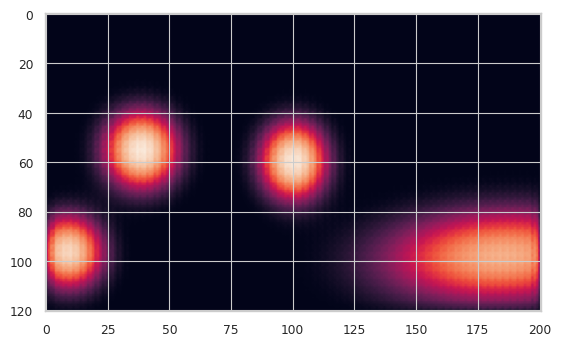

In [62]:
img = test_data[0]
print(img.shape)
plt.imshow(img)
new_img = tf.expand_dims(img, 0)
print(new_img.shape)
prediction = autoencoder.model.predict(new_img)
print(prediction.shape)
plt.imshow(prediction[0])

(2791, 121, 201, 1)

88/88 [==============================] - 0s 5ms/step


(2791, 121, 201, 1)

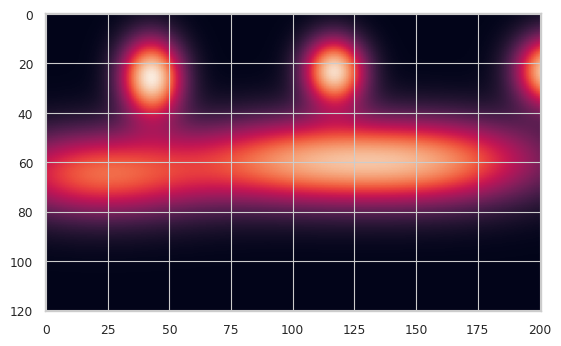

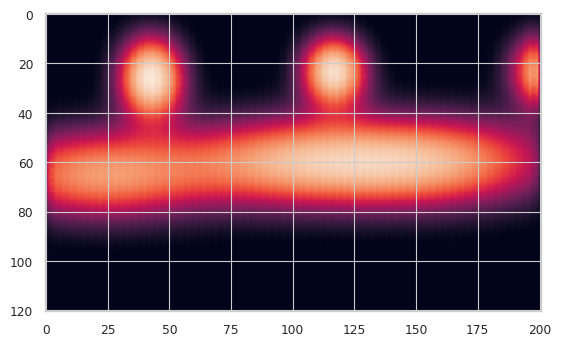

In [68]:
print(test_data.shape)
# new_test_data = tf.expand_dims(test_data, 0)
# print(new_test_data.shape)
# new_img = tf.expand_dims(new_test_data, -1)
# print(new_test_data.shape)
prediction = autoencoder.model.predict(test_data)
print(prediction.shape)

plt.imshow(test_data[89])
plt.show()
plt.imshow(prediction[89])
plt.show()